# Clustering and Downstream Analysis

## Imports

In [1]:
import glob
import time
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf
import pickle
from guacamol.common_scoring_functions import CNS_MPO_ScoringFunction
from guacamol.utils.descriptors import mol_weight, logP, num_H_donors, tpsa, num_atoms, AtomCounter
from contextlib import closing
from multiprocessing import Pool
import multiprocessing
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from functools import partial
import argparse
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import SDWriter
from rdkit import RDLogger
import time
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# Matplotlib changes 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)


## Helpers

In [2]:
# Create custom cmap
color1 = "#4285f4"  # "#1a237e" 
color2 = "#0f9d58"  
color3 = "#f4b400" 

# Create a custom colormap using LinearSegmentedColormap
cmap_name = 'custom_colormap'
n_colors = 256  # Number of colors in the colormap

# Create a list of colors that smoothly transition from color1 to color2 to color3
colors = [color1, color2, color3]

# Create a colormap with a smooth transition
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_colors)

# import chemfp

## Step 1 : Clustering

**Summary: Cluster the molecules and extract the best performing molecule of each cluster that will be then docked with Vina.**

As we have a large number of molecules to cluster (3 million), we cannot use a traditional Butina clustering with RDKit. Following   https://www.macinchem.org/reviews/clustering/clustering.php we can cluster molecules with Chemfp, which does allow clustering larger libraries. We can use 1.x developer line, which is non-commercial. Important to note is that Chemfp 1.x is **not compatibile with Python 3**, hence we have to create a separate environment that will run the code in **Python 2.7**. All steps to create environment, install combatibile RDKit (versions before 2019) and finally chemfp iis shown below.

In [58]:
# conda create -y -n DD_protocol_py27 python=2.7
# conda activate DD_protocol_py27
# conda install -c rdkit rdkit=2018.09.1
# pip install chemfp

### Step 1.1: Get fingerprints

Now, to create a compatibile fingerprints from smiles for the molecules we want to cluster we can do. We preserve the same fingerprint settings as for the pipeline steps - Morgan, fingerprint size 1024, radius 2 and taking chirality into account.

In [59]:
# sbatch --account=VENDRUSCOLO-SL3-CPU --partition=skylake --nodes=1 --ntasks=1 --cpus-per-task=10 --time=02:00:00 --wrap="rdkit2fps extracted_smiles.smi --fpSize 1024 --morgan --radius 2 --useChirality 1 > extracted_smiles.fps"

### Step 1.2: Get clusters

In [60]:
# sbatch --account=VENDRUSCOLO-SL3-CPU --partition=skylake --nodes=1 --ntasks=1 --cpus-per-task=15 --time=10:30:00 --wrap="python /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/scripts_3/taylor_butina.py --profile --threshold 0.78 extracted_smiles.fps -o extracted_smiles_clusters.txt"

### Step 1.3: (TODO: DEPRECATE) Look at clusters and presence of 2D molecules

In [3]:
molecules = pd.read_csv('clustering_results/clusters_1024_with_scores.txt', sep=",", header=None)
molecules = molecules.rename(columns={0: 'molecule', 1: 'cluster', 2: 'score'})
ligands_2d = pd.read_csv("clustering_results/molecule_testing/2D_ligands.txt", names=['molecule'])

In [3]:
smiles = pd.read_csv('extracted_smiles.smi', sep=" ", names=['smile', 'molecule'])

In [63]:
(pd.merge(smiles, ligands_2d, on='molecule')).to_csv('test_clustering_2d_molecules/2d_ligands.smi', index=False, header=False, sep=" ")

### Step 1.4: Get the best predicted scoring molecule from each cluster

Get the best predicted scoring molecule from each cluster, this will be used in the next step (Vina docking).


#### Step 1.4.1: Get scores for all molecules that were clusters (merge cluster table with scores table)

In [64]:
# join -1 2 -2 1 -t , <(sort -k2 -t , clusters_1024.txt) <(sort -k1 -t , ../../id_score.csv) > clusters_1024_with_score.txt

#### Step 1.4.2: Get molecule with the highest score from each cluster

In [65]:
molecules = pd.read_csv('clustering_results/clusters_1024_with_scores.txt', sep=",", header=None)
molecules = molecules.rename(columns={0: 'molecule', 1: 'cluster', 2: 'score'})
idx = molecules.groupby("cluster")["score"].transform(max) == molecules["score"]
best_scoring = molecules[idx]
# if there are multiple molecules with the best score from the cluster, keep only one of them
best_scoring = best_scoring.drop_duplicates(subset='cluster', keep="first")

# print(len(molecules["cluster"].unique()))
# print(len(best_scoring["cluster"]))
# print(len(best_scoring["cluster"].unique()))
# duplicates =  best_scoring[best_scoring["cluster"].duplicated()]
# best_scoring[best_scoring["score"]==1][1:30]

len(best_scoring['score'])
best_scoring.molecule.to_csv('clustering_results/clusters_1024_best_scores.txt',index = False, header=False)



## Step 2: Vina docking 

**Summary: Dock the best predicted molecules from each cluster with Vina and process results. Extract top 100,000 molecules that will be later docked with FRED.**

### Step 2.1: Process clusters and  singletons, isolate isomers ( have "_" in their ID ) and non-isomers

In [11]:
# !mkdir clustering_results/molecule_testing
# !grep -v "_" clustering_results/clusters_1024_best_scores.txt > clustering_results/molecule_testing/clusters-no-isomers.txt
# !grep "_" clustering_results/clusters_1024_best_scores.txt > clustering_results/molecule_testing/clusters-isomers_ids.txt


Get smiles for the molecules that will have conformations generated instead of downloaded

In [12]:
ids = pd.read_csv("clustering_results/molecule_testing/clusters-isomers_ids.txt", header=None)
ids = ids.rename(columns={0: 'ZINC_ID'})
smiles = pd.read_csv("extracted_smiles.smi", sep=" ", header=None)
smiles = smiles.rename(columns={0: 'smiles', 1: 'ZINC_ID'})
to_extract = pd.merge(ids, smiles, on='ZINC_ID')
to_extract = to_extract[['smiles', 'ZINC_ID']]
# to_extract.to_csv("clustering_results/molecule_testing/clusters-isomers.smi", sep=" ", index = False, header=False)

### Step 2.2 Download or create conformations based on if they are isomers or non-isomers. 

The code below can be used

In [68]:
!cat download_and_create_conformations.sh

#!/bin/bash

folder=$1
n_cpus_per_node=$2
name_cpu_partition=$3
account_name=$4

# Create directory where to store ligands. Directory is called pdbqt despite us downloading SDFs as we are going to convert
# them later.
pdbqt_directory="pdbqt"
mkdir -p ${folder}/$pdbqt_directory  || { echo 'Error creating directory' ; exit 1; }


#### DO DOWNLOAD FOR ALL MOLECULES THAT ARE NOT HAVING ISOMERS ####
# For each file of form (*-no-isomers.txt) [* = clusters] perform 
# the download of sdfs for all ZINC IDs contained in them
echo "Downloading ligands for molecules that do not have geometric isomers"
for f in ${folder}/clusters-no-isomers.txt
do
   tmp="$f"
   filename="${tmp##*/}"
   set_type="${filename%%-*}" # clusters
   
   mkdir -p ${folder}/${pdbqt_directory}/${set_type}_download || { echo 'Error creating directory' ; exit 1; }
   mkdir -p ${folder}/${set_type}_set_scripts || { echo 'Error creating directory' ; exit 1; }
   
   # Create scripts to download SDFs of chunks of size 1000
  

### Step 2.3: Prepare downloaded/created conformations for docking. 

The code below can be used.

In [69]:
!cat prepare_conformations_for_docking.sh

#!/bin/bash

#SBATCH --account VENDRUSCOLO-SL3-CPU
#SBATCH --partition skylake
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --time=04:00:00

module load gcc
module load boost-1.66.0-gcc-5.4.0-sdffwvs

folder=$1
name_cpu_partition=$2
account_name=$3
obabel_path=$4

path_to_pdbqt=${folder}/pdbqt

 #For each dataset (download/creation) go over the sdf files containing the chunk of ligand conformations and split them so we have
 # 1 sdf per ligand conformation. Store these single sdf files within "chunk" directory that contains all sdfs coming from the larger sdf file, so these directories can be process in parallel in next steps.
 for d in ${path_to_pdbqt}/clusters_creation;
 do
 tmp="$d"
 directory_set_name="${tmp##*/}"
 echo "Processing SDFs in ${directory_set_name}"
    for f in $d/*.sdf
    do
        tmp="$f"
        full_filename="${tmp##*/}"
        filename="${full_filename%.*}"
        echo "Processing ${filename}"
        mkdir -p $d/${filename} 
     

### Step 2.4: Check if downloads were successful (if everything was downloaded). 

The code below can be used.

In [70]:
!cat show_download_stats.sh

#!/bin/bash
shopt -s extglob

folder=$1 # main folder with results
chunk_size=$2 # how many compounds should the downloaded chunk contain
chunk_pattern=$3 # naming pattern of downloaded chunk files
# Go to directory with the current iteration
cd $folder

pdbqt_directory="pdbqt"

# For each batch file that has less compounds downloaded than $number_of_mols_to_expect, repeat the download
echo "**Retries required based on number of compounds**"
for d in ${pdbqt_directory}/*_download;
do
   tmp="$d"
   directory_set_name_full="${tmp##*/}"
   set_type="${directory_set_name_full%_*}" # train/test/validation
   echo "Current set:"
   echo $set_type

   echo "Following downloads have to be repeated:"
   for f in $d/${chunk_pattern}
   do
       x=$(grep -wc "\$\$\$\$" < "$f")
       if [ $x -lt ${chunk_size} ];
       then
           tmp="$f"
           full_filename="${tmp##*/}"
           filename="${full_filename%.*}"
           chunk_filename=${set_type}_set_scripts/${filename}.txt
       

### Step 2.5: Retry the downloads if needed.

The code below can be used.

In [71]:
!cat retry_downloads.sh

#!/bin/bash
shopt -s extglob

#SBATCH --account VENDRUSCOLO-SL3-CPU
#SBATCH --partition skylake
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --time=02:00:00

folder=$1
n_cpus_per_node=$2
name_cpu_partition=$3
account_name=$4
original_chunk_size=$5
original_chunk_pattern=$6
new_chunk_size=$7

# Go to directory with the current iteration
cd $folder

pdbqt_directory="pdbqt"

# For each batch file that has not been downloaded due to request failure, run the download again.
echo "retry based on number of lines"
for d in ${pdbqt_directory}/*_download;
do
tmp="$d"
directory_set_name_full="${tmp##*/}"
set_type="${directory_set_name_full%_*}" # train/test/validation
echo $set_type
   for f in $d/${original_chunk_pattern}
   do
       x=$(wc -l < "$f")
       if [ $x -lt 1000 ];
       then
           tmp="$f"
           full_filename="${tmp##*/}"
           filename="${full_filename%.*}"
           script_name=${set_type}_set_scripts/download_${filename}.sh
          

### Step 2.6: Dock the ligands with Vina. 

The code below can be used.

In [72]:
!cat vina_dock_conformations.sh

#!/bin/bash

#SBATCH --cpus-per-task=1
#SBATCH --account=VENDRUSCOLO-SL3-GPU
#SBATCH --partition ampere
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --gres=gpu:1
#SBATCH --job-name=phase_3
#SBATCH --time=01:00:00

# PARAMETERS
folder=$1
use_vina_gpu=$2
account_name=$3
partition=$4
configuration_file=$5
receptor=$6
vina_path=$7


# Establish paths used in docking for inputs (pdbqt directory) and outputs (docked directory)
mkdir -p ${folder}/docked
path_to_pdbqt=${folder}/pdbqt
path_to_docked=${folder}/docked

# For each set (creation/download) directory, create a matching directory in docked (output) directory and run batches within 
# each directory as a separate job.
for d in ${path_to_pdbqt}/*;
do
    tmp="$d"
    directory_set_name="${tmp##*/}"
    echo "Processing PDBQTs in ${directory_set_name}"
    # Create matching directory in docked (output) directory
    mkdir -p ${path_to_docked}/${directory_set_name} || { echo 'Creating directory failed' ; exit 1; }
    # For each batch wit

### Step 2.7: Analyse docked compounds and get top 100000 best scoring molecules that will later be used for docking with FRED.

The code below can be used.

In [73]:
!cat analyse_docked_compounds.py

#!/usr/bin/python

import sys
sys.path.insert(0,"../scripts_3")
from extract_scores_vina import extract_scores
import pandas  as  pd
import os, fnmatch
from argparse import ArgumentParser

# Helper function to convert the molecule to path to it
def convert_to_filename(zinc_id, path_to_molecules):
    if "_" in zinc_id:
        return path_to_molecules + "/clusters_creation/" + zinc_id + "_out.pdbqt"
    else:
        return path_to_molecules + "/clusters_download/" + zinc_id + "_out.pdbqt"

# # Helper function to find the molecule's docking output file
# def find(pattern, path):
#     result = []
#     for root, dirs, files in os.walk(path):
#         for name in files:
#             if fnmatch.fnmatch(name, pattern):
#                 result.append(os.path.join(root, name))
#     return result

def get_selected_molecules(directories_to_process, number_of_molecules_to_extract, path_to_molecules):
    
    # Get labels and corresponding ZINC_IDs
    full_labels = extract_scores(director

In [74]:
# labels = pd.read_csv("clustering_results/molecule_testing/clusters_labels.txt",  delimiter=',')
# labels[labels["r_i_docking_score"] < -8.5]

## Step 3: Fred docking 

**Summary: Dock the 100,000 molecules with FRED. These results will be later used in joined analysis with Vina docking.**

### Step 3.1 Dock the best Vina conformations with FRED. 

The code below can be used. This code takes the best Vina-scoring pose that is then FRED-docked.

In [75]:
!cat fred_dock_conformations.sh

#!/bin/bash

#SBATCH --cpus-per-task=10
#SBATCH --account=VENDRUSCOLO-SL3-CPU
#SBATCH --partition skylake
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --job-name=fred_docking
#SBATCH --time=01:00:00

# obabel=/home/mb2462/test/DD_protocol_data/OPENBABEL/build/bin/obabel
# oe_license=/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/oe_license.txt
# receptor=/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/receptor.pdb
# openeye=/home/mb2462/rds/hpc-work/DD/DD_protocol_data/openeye

file_with_selected_molecules=$1
directory_to_store=$2
obabel=$3
oe_license=$4
receptor=$5
openeye=$6
n_cpus_per_node=$7
name_cpu_partition=$8
account_name=$9

fred_directory=${directory_to_store}/fred_docked || { echo 'Creating directory failed' ; exit 1; }
mkdir $fred_directory || { echo 'Changing directory directory failed' ; exit 1; }

# Split the file containing smiles into chunks of 1000
split -l 500 --additional-suffix=.txt ${file_with_selected_molecules} ${fr

### Step 3.2: Process Fred results

Concat results from chunks together (+ add which chunk the ligand belongs to)

In [76]:
# for f in /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/fred_docked/*/*_docking_results.txt; do awk -F$'\t' '{print $1, $2, FILENAME}' $f >> fred_docking_scores.txt; done

## Step 4: Analyse Vina and Fred results and get top molecules

**Summary: Analyse results of Vina and Fred docking and get a list of the top molecules following a method that combines both scores. These top molecules are then further filtered by their fitness for central nervous system in the following step.**

### Step 4.1: Get the molecules with Vina scores and with FRED scores and also sort them.

Here we are also doing adjustment by removing 2D molecules, which should not be necessary in the future runs.

In [2]:
# get vina docked scores and fred scores
vina_docked = pd.read_csv("clustering_results/molecule_testing/clusters_selected_molecules.txt")
fred_docked = pd.read_csv("clustering_results/molecule_testing/fred_docking_scores.txt",delimiter=' ', names=['ZINC_ID', "FRED_score", "chunk"] )
# get list of ligands that were 2D 
# TODO: remove the need to remove 2d ligands
ligands_2d = pd.read_csv("clustering_results/molecule_testing/2D_ligands.txt", names=['ZINC_ID'])

# VINA cleanup - remove 2D ligands, sort by docking score and rename the headers
vina_cleaned = pd.merge(vina_docked, ligands_2d, on='ZINC_ID',how='left', indicator=True)
vina_cleaned =  vina_cleaned[vina_cleaned['_merge'] == 'left_only']
vina_cleaned_sorted = vina_cleaned.sort_values('r_i_docking_score')
vina_cleaned_sorted = vina_cleaned_sorted.drop('_merge',axis=1)
vina_cleaned_sorted = vina_cleaned_sorted.rename(columns={'r_i_docking_score' : 'VINA_score', 'file': "VINA_filename"})

# FRED cleanup - remove 2D ligands, sort by docking score and rename the headers
fred_cleaned = pd.merge(fred_docked, ligands_2d, on='ZINC_ID',how='left', indicator=True)
fred_cleaned =  fred_cleaned[fred_cleaned['_merge'] == 'left_only']
fred_cleaned_sorted = fred_cleaned.sort_values('FRED_score')
fred_cleaned_sorted = fred_cleaned_sorted.drop('_merge',axis=1)
fred_cleaned_sorted['FRED_filename'] = fred_cleaned_sorted.apply(lambda x: x['chunk'].rsplit('/',1)[0] + '/out_files/' + x['ZINC_ID'] + '_fred_out.sdf', axis=1)
fred_cleaned_sorted = fred_cleaned_sorted.drop('chunk',axis=1)

ligands_both_scores = pd.merge(vina_cleaned_sorted, fred_cleaned_sorted, on='ZINC_ID')
ligands_both_scores= ligands_both_scores[['ZINC_ID', "VINA_score", "VINA_filename", "FRED_score", "FRED_filename"]]


In [13]:
# TODO: not needed
# fred_2ds = pd.merge(fred_docked, ligands_2d, on='ZINC_ID',indicator=True)
# fred_score_2d = pd.merge(fred_docked, ligands_2d, on='ZINC_ID')

Print best and worst Vina and FRED scores as well as ratio to normalize differences.

In [6]:
print('Worst VINA score: ' + str(ligands_both_scores['VINA_score'].max()))
print('Best VINA score: ' + str(ligands_both_scores['VINA_score'].min()))
print('Mean VINA score: ' + str(ligands_both_scores['VINA_score'].mean()))
print('Worst FRED score: ' + str(ligands_both_scores['FRED_score'].max()))
print('Best FRED score: ' + str(ligands_both_scores['FRED_score'].min()))
print('Mean FRED score: ' + str(ligands_both_scores['FRED_score'].mean()))

abs(ligands_both_scores['FRED_score'].max() - ligands_both_scores['FRED_score'].min())/abs(ligands_both_scores['VINA_score'].max() - ligands_both_scores['VINA_score'].min())

Worst VINA score: -6.7
Best VINA score: -8.4
Mean VINA score: -6.9462334667953565
Worst FRED score: -0.183394
Best FRED score: -9.308925
Mean FRED score: -4.0


5.367959411764706

### Step 4.2: Try various methods to select the top molecules.

#### Step 4.2.1: Method 1 - Top 8000 and overlap

Following code takes VINA and FRED scores for molecules, based on both scores, it sorts them respectively and takes top 8000 for each respectively. Then finds intersection of the top 8000 for both scores.

Here we are also doing adjustment by removing 2D molecules, which should not be necessary in the future runs.

In [19]:
top_8000_vina_cleaned_sorted = vina_cleaned_sorted.head(8000)
top_8000_fred_cleaned_sorted = fred_cleaned_sorted.head(8000)

top_8000_final_top= pd.merge(top_8000_vina_cleaned_sorted, top_8000_fred_cleaned_sorted, how='inner', on=['ZINC_ID'])

top_8000_final_top = top_8000_final_top[['ZINC_ID', "VINA_score", "FRED_score"]]

<AxesSubplot:title={'center':'Top overlap Top Ligands'}, xlabel='VINA_score', ylabel='FRED_score'>

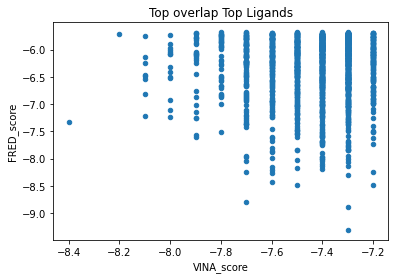

In [20]:
top_8000_final_top.plot.scatter(x="VINA_score", y="FRED_score", title= "Top overlap Top Ligands")

#### Step 4.2.2: Method 2 - Normalize scores and sum
Use min-max normalization to get values between 0 and 1 for both scores. Then take the same amount of top molecules as we got from Method 1 (for consistency of number).

In [22]:
normalized_ligands_both_scores = ligands_both_scores.copy()
normalized_ligands_both_scores['VINA_score_normalized'] = (normalized_ligands_both_scores['VINA_score']-normalized_ligands_both_scores['VINA_score'].min())/(normalized_ligands_both_scores['VINA_score'].max()-normalized_ligands_both_scores['VINA_score'].min())
normalized_ligands_both_scores['FRED_score_normalized'] = (normalized_ligands_both_scores['FRED_score']-normalized_ligands_both_scores['FRED_score'].min())/(normalized_ligands_both_scores['FRED_score'].max()-normalized_ligands_both_scores['FRED_score'].min())


normalized_ligands_both_scores['joined_score_normalized'] = normalized_ligands_both_scores['VINA_score_normalized'] + normalized_ligands_both_scores['FRED_score_normalized']
top_normalized_ligands_both_scores  = normalized_ligands_both_scores.sort_values('joined_score_normalized').head(1561)


<AxesSubplot:title={'center':'Normalized Sum Top Ligands'}, xlabel='VINA_score', ylabel='FRED_score'>

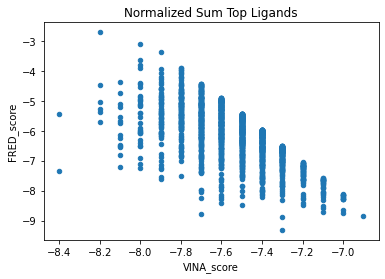

In [23]:
top_normalized_ligands_both_scores.plot.scatter(x="VINA_score", y="FRED_score",title="Normalized Sum Top Ligands")

#### Step 4.2.3: Method 3 - Combined method

Use normalized values and sorting of Method 2 but remove all the molecules that have scores worse than the worst performing molecules of Method 1 for Vina and FRED respectively. Then take the same amount of top molecules as we got from Method 1 (for consistency of number).

In [24]:
filtered_normalized_ligands_both_scores = normalized_ligands_both_scores[normalized_ligands_both_scores['VINA_score'] <= top_8000_final_top['VINA_score'].max()]
filtered_normalized_ligands_both_scores = filtered_normalized_ligands_both_scores[filtered_normalized_ligands_both_scores['FRED_score'] <= top_8000_final_top['FRED_score'].max()]
top_filtered_normalized_ligands_both_scores = filtered_normalized_ligands_both_scores.sort_values('joined_score_normalized').head(1561)

<AxesSubplot:title={'center':'Filtered Normalized Top Ligands'}, xlabel='VINA_score', ylabel='FRED_score'>

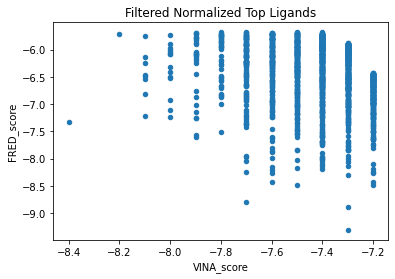

In [30]:
top_filtered_normalized_ligands_both_scores.plot.scatter(x='VINA_score', y='FRED_score', title="Filtered Normalized Top Ligands")

#### Step 4.2.4: Method 4 - Scaled sum - UPDATE: identical to normalization

In [28]:
scaling_factor = abs(ligands_both_scores['FRED_score'].max() - ligands_both_scores['FRED_score'].min())/abs(ligands_both_scores['VINA_score'].max() - ligands_both_scores['VINA_score'].min())

scaled_sum_ligands_both_scores = ligands_both_scores.copy()
scaled_sum_ligands_both_scores['combined_score'] = scaling_factor*scaled_sum_ligands_both_scores['VINA_score'] + scaled_sum_ligands_both_scores['FRED_score']
top_scaled_sum_ligands_both_scores = scaled_sum_ligands_both_scores.sort_values('combined_score').head(1561)

<AxesSubplot:title={'center':'Scaled Sum Top Ligands'}, xlabel='VINA_score', ylabel='FRED_score'>

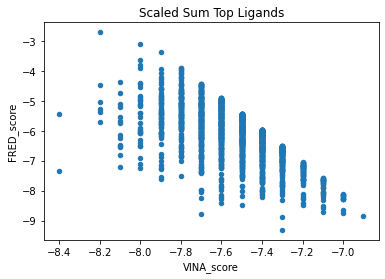

In [29]:
top_scaled_sum_ligands_both_scores.plot.scatter(x='VINA_score', y='FRED_score', title="Scaled Sum Top Ligands")

### Step 4.3: Combine methods and find overlap

Combine the methods and find overlapping molecules that are found in the top results in all methods.

In [34]:
ligands_top_8000_final_top = set(top_8000_final_top['ZINC_ID'])
ligands_top_normalized_ligands_both_scores = set(top_normalized_ligands_both_scores['ZINC_ID'])
ligands_top_scaled_sum_ligands_both_scores = set(top_scaled_sum_ligands_both_scores['ZINC_ID'])
ligands_top_filtered_normalized_ligands_both_scores = set(top_filtered_normalized_ligands_both_scores['ZINC_ID'])

Show the overlap

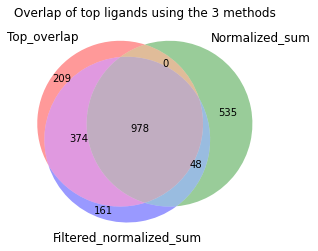

In [35]:
venn3([ligands_top_8000_final_top, ligands_top_normalized_ligands_both_scores, ligands_top_filtered_normalized_ligands_both_scores], ('Top_overlap', 'Normalized_sum', 'Filtered_normalized_sum'))

plt.title("Overlap of top ligands using the 3 methods")
plt.show()

Get the overlap and save the results

In [36]:
top_consensus = pd.merge(top_8000_final_top, top_normalized_ligands_both_scores, on=['ZINC_ID'])
top_consensus = top_consensus[['ZINC_ID', 'VINA_score_x', 'VINA_filename', 'FRED_score_x', 'FRED_filename']]
top_consensus =top_consensus.rename(columns={'VINA_score_x' : 'VINA_score', 'FRED_score_x': "FRED_score"})
# top_consensus.to_csv("clustering_results/molecule_testing/top_consensus.csv", header=False, index=False)

### Step 4.4: Exploring consensus molecules

In [2]:
top_consensus = pd.read_csv("clustering_results/molecule_testing/top_consensus.csv", names=["ZINC_ID", "VINA_score", "VINA_filename", "FRED_score", "FRED_filename"])

In [3]:
print(top_consensus["VINA_score"].min())
print(top_consensus["VINA_score"].max())
print(top_consensus["VINA_score"].mean())
print(top_consensus["FRED_score"].min())
print(top_consensus["FRED_score"].max())
print(top_consensus["FRED_score"].mean())

-8.4
-7.2
-7.512576687116487
-9.308925
-5.681838
-6.537440245398768


## Step 5: Final molecule selection (small number to experimentally test)
**Summary: Make a final molecule selection that will be experimentally tested. Here we are exploring fitness of molecules for central nervous system.**

### Step 5.1 : Method 1 - Strict conditions for BBB penetration - Update: not used

In [39]:
# #suppl = Chem.SDMolSupplier('clustering_results/molecule_testing/top_consensus_fred.sdf')
# # molecules = [x for x in Chem.ForwardSDMolSupplier(open('clustering_results/molecule_testing/top_consensus_fred.sdf')) if x is not None]
# molecules = [x for x in Chem.ForwardSDMolSupplier(open('/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/top_consensus_fred.sdf','rb')) if x is not None]
# len(molecules)
# output_list = []
# for m in molecules:
#     if(m):
#         logP = Descriptors.MolLogP(m)
#         molWt = Descriptors.MolWt(m)
#         TPSA = Descriptors.TPSA(m)
#         HBD = Chem.rdMolDescriptors.CalcNumHBD(m)
#         if(logP <= 3 and molWt <= 360
#             and TPSA >= 40 and TPSA <= 90
#             and HBD <= 0.5):
#             output_list.append(m.GetProp('_Name'))
# # len(output_list)
# # output_list

In [40]:
# indexes = []
# for index,zinc_id in enumerate(top_consensus["ZINC_ID"]):
#     if zinc_id in output_list:
#         indexes.append(index)

# # print(indexes)

In [23]:
# top_consensus.iloc[indexes]

### Step 5.2: Method 2 - Clustering of top consensus - Update: not used, molecules are too different based on the first clustering

First lets prepare put sdf files of top ligands together to one file.

In [ ]:
#!awk -F',' '{print $NF}' top_consensus.csv > top_consensus_fred_filenames.txt
#!while read p; do cat $p >> top_consensus_fred.sdf; done <top_consensus_fred_filenames.txt

Now let's perform the clustering

In [ ]:
#!conda activate DD_protocol_py27
#! rdkit2fps top_consensus_fred.sdf --fpSize 1024 --morgan --radius 2 --useChirality 1 > top_consensus_fred.fps
#! sbatch --account=VENDRUSCOLO-SL3-CPU --partition=skylake --nodes=1 --ntasks=1 --cpus-per-task=10 --time=02:00:00 --wrap="python /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/scripts_3/taylor_butina.py --profile --threshold 0.78 top_consensus_fred_check.fps -o top_consensus_fred_check_clusters.txt"


### Step 5.3: Method 3 - Using DeePred-BBB and Gaucamol MPO scoring

#### Step 5.3.1: Get smiles from (FRED) SDF files.

These are the molecules and poses we have the scores for.

In [ ]:
# !python ../scripts_3/sdftosmile.py -file clustering_results/molecule_testing/top_consensus_fred.sdf -path_to_store clustering_results/molecule_testing 

#!cp clustering_results/molecule_testing/top_consensus_fred.smi /home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/smiles.smi

#### Step 5.3.2: Use DeePred-BBB (https://github.com/12rajnish/DeePred-BBB) to get permeability prediction.

(Not used) but for altered code to display scores rounded to 2 decimal places instead of 0 vs 1, perform this change, change line 19 and 20 in DeePred-BBB_Script.py as below. However, it might be better to just take the scores as binary.

In [ ]:
#prediction = loaded_model.predict(bbb_user_input).round(2)
#prediction = prediction[:,0].astype(float)

##### Step 5.3.2.1: Process results (prediction.csv and feature.csv)

Create  table merging their feature scores, VINA score, FRED score and path to their Vina and FRED sdfs

In [58]:
# feature_loginq = pd.read_csv("/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/feature.csv")
# prediction_loginq = pd.read_csv("/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/prediction.csv", header=None, names=["Predicted"])

# feature = pd.read_csv("/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/results_used/feature.csv")
# prediction = pd.read_csv("/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/results_used/prediction.csv", header=None, names=["Predicted"])


In [59]:
# # merged_loginq = pd.merge(feature_loginq, prediction_loginq, left_index=True, right_index=True)
# merged= pd.read_csv("clustering_results/molecule_testing/top_consensus_permeability_without_changes.csv")

# # all_merged = pd.merge(merged, merged_loginq, on="Name")
# # all_merged[all_merged["Name"]=="ZINC000226296427"][["Name","Predicted_x", "Predicted_y"]]
# shortened = pd.merge(merged,predbbb, on="Name")[["Name", "ALogP_x", "ALogP_y", "Predicted_x", "Predicted_y"]]
# # shortened['Predicted_x_rounded'] = shortened.Predicted_x.round()
# # shortened = shortened.dropna()
# shortened['difference'] = shortened['Predicted_x'] - shortened['Predicted_y']

In [84]:
top_consensus = pd.read_csv("clustering_results/molecule_testing/top_consensus.csv", names=["Name", "VINA_score", "VINA_filename", "FRED_score", "FRED_filename"])
top_consensus_fred_filenames = top_consensus[["Name", "FRED_filename"]]

In [83]:
# # predbbb_feature = pd.read_csv("/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/results_used/feature.csv")
# # predbbb_prediction = pd.read_csv("/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DeePred-BBB-main/DeePred-BBB/results_used/prediction.csv", header=None, names=["Predicted"])
# # predbbb_merged = pd.merge(feature, prediction, left_index=True, right_index=True)
predbbb = pd.read_csv("clustering_results/molecule_testing/top_consensus_permeability_tensor.csv")
predbbb = predbbb.sort_values(by=['Predicted'],ascending=False)
# # predbbb.to_csv("clustering_results/molecule_testing/top_consensus_deeppredbbb_sorted.csv")

#### Step 5.3.3: Get CNS_MPO Guacamol scores

Calculate Guacamole score. Also calculate accompanying values for chemical properties (this is used for having a more comprehensive table for each molecule later).

In [62]:
molecules = [x for x in Chem.ForwardSDMolSupplier(open('/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/top_consensus_fred.sdf','rb')) if x is not None]
mpo_scores = []
mpo_names = []
mpo_mw = []
mpo_lp = []
mpo_hbd = []
mpo_mol_tpsa = []
CNS = CNS_MPO_ScoringFunction()
for mol in molecules:
    score = CNS.score_mol(mol)
    mpo_scores.append(score)
    mpo_names.append(mol.GetProp('_Name'))
    mpo_mw.append(mol_weight(mol))
    mpo_lp.append(logP(mol))
    mpo_hbd.append(num_H_donors(mol))
    mpo_mol_tpsa.append(tpsa(mol))

Create table with values

In [63]:
mpo_dict = {'Name' : mpo_names, 
            'Mol_Weight': mpo_mw, 
            'LogP' : mpo_lp, 
            'Num_H_donors' : mpo_hbd, 
            "TPSA" : mpo_mol_tpsa,
            'MPO_score':mpo_scores}
mpo= pd.DataFrame(mpo_dict)
mpo= mpo.sort_values(by="MPO_score", ascending=False)
# mpo.to_csv("clustering_results/molecule_testing/top_consensus_mpo.csv", index=False)


#### Step 5.3.4: Merge all the results 

Merge MPO scores and DeePred-BBB scores as well as Vina and FRED scores and store it.

In [3]:
# merged_mpo_predbbb = pd.merge(mpo, predbbb, on="Name")
# merged_mpo_predbbb_vina_fred_scores  =  pd.merge(merged_mpo_predbbb, top_consensus, on="Name")
# clean_merged_mpo_predbbb_vina_fred_scores = merged_mpo_predbbb_vina_fred_scores[["Name", 'Mol_Weight', 'LogP', "Num_H_donors", "TPSA", "MPO_score", "Predicted", "VINA_score", "FRED_score"]]
# clean_merged_mpo_predbbb_vina_fred_scores = clean_merged_mpo_predbbb_vina_fred_scores.rename(columns={'Predicted': 'DeePred-BBB Prediction'}) 
# clean_merged_mpo_predbbb_vina_fred_scores.to_csv("clustering_results/molecule_testing/top_consensus_all_scores.csv")
# clean_merged_mpo_predbbb_vina_fred_scores

clean_merged_mpo_predbbb_vina_fred_scores = pd.read_csv("clustering_results/molecule_testing/top_consensus_all_scores.csv")
# clean_merged_mpo_predbbb_vina_fred_scores

Display MPO, VINA and FRED score in one plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


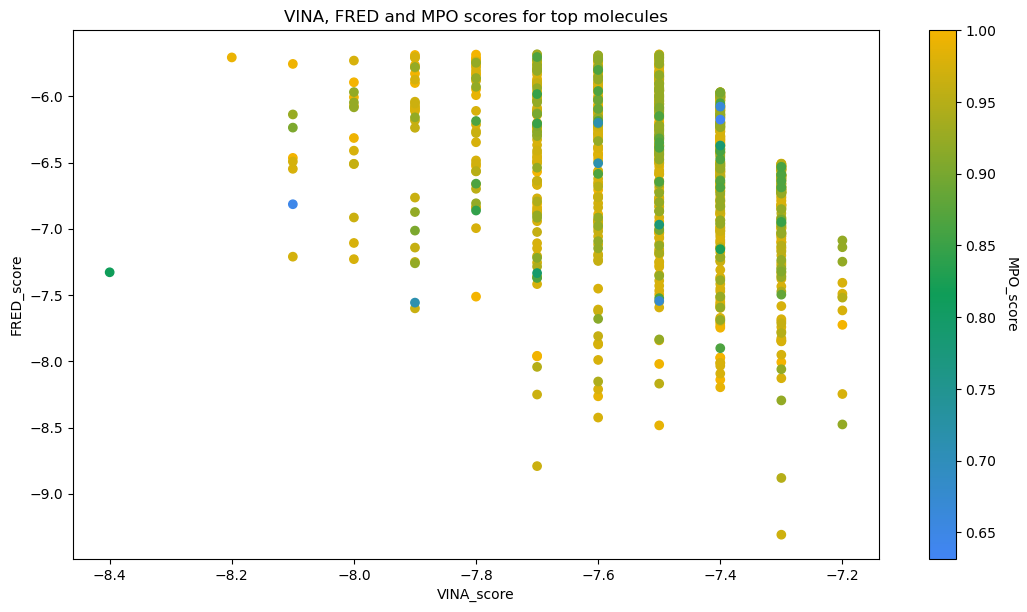

In [4]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("top_consensus_all_scores_graphs.pdf")
fig = plt.figure(dpi=100, figsize=(13, 7)) 
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores['FRED_score'],
            c= clean_merged_mpo_predbbb_vina_fred_scores['MPO_score'],  cmap=custom_cmap, alpha=1)


cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('MPO_score', rotation=270)
plt.xlabel('VINA_score')
plt.ylabel('FRED_score')
plt.title('VINA, FRED and MPO scores for top molecules')
# pdf.savefig( fig )
plt.show()


Display VINA, FRED scores and DeePred-BBB passing prediction in one plot.

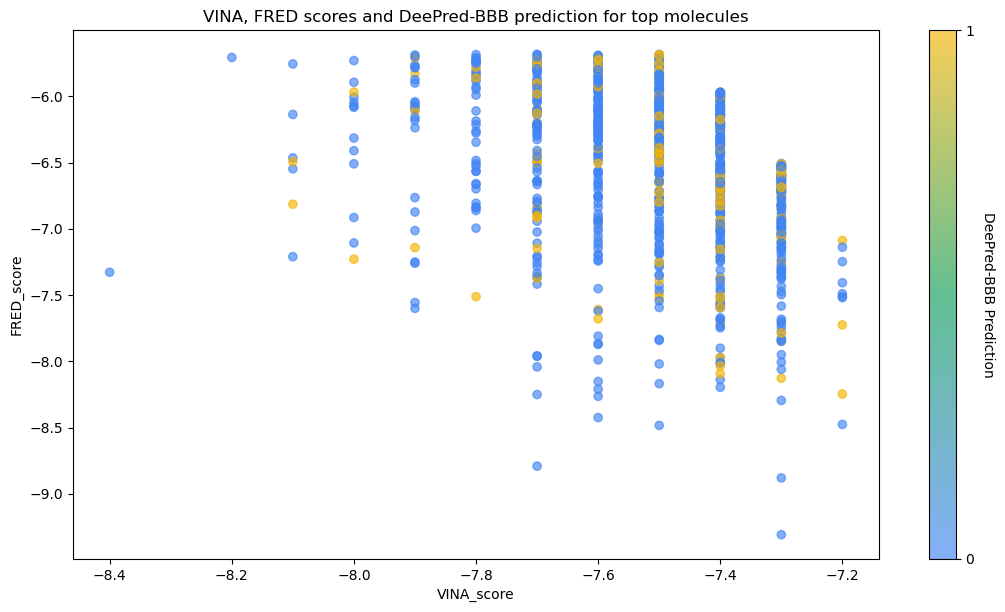

In [5]:
fig = plt.figure(dpi=100, figsize=(13, 7)) 

clean_merged_mpo_predbbb_vina_fred_scores = clean_merged_mpo_predbbb_vina_fred_scores[clean_merged_mpo_predbbb_vina_fred_scores['DeePred-BBB Prediction']>-1]
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores['DeePred-BBB Prediction'],  cmap=custom_cmap,  alpha=0.65)

cbar = plt.colorbar(ticks=np.linspace(0,1,2))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('DeePred-BBB Prediction', rotation=270)
plt.xlabel('VINA_score')
plt.ylabel('FRED_score')
plt.title('VINA, FRED scores and DeePred-BBB prediction for top molecules')
# pdf.savefig( fig )
plt.show()

### Step 5.4: Final selection

####  Step 5.4.1: Final selectionGet all data passing DeePred-BBB (=1) and having MPO score > 0.9

In [6]:
clean_merged_mpo_predbbb_vina_fred_scores_passing = clean_merged_mpo_predbbb_vina_fred_scores[clean_merged_mpo_predbbb_vina_fred_scores['DeePred-BBB Prediction']==1]
clean_merged_mpo_predbbb_vina_fred_scores_passing = clean_merged_mpo_predbbb_vina_fred_scores_passing[clean_merged_mpo_predbbb_vina_fred_scores_passing['MPO_score']>0.9]

Show Vina FRED and MPO score for the passing molecules.

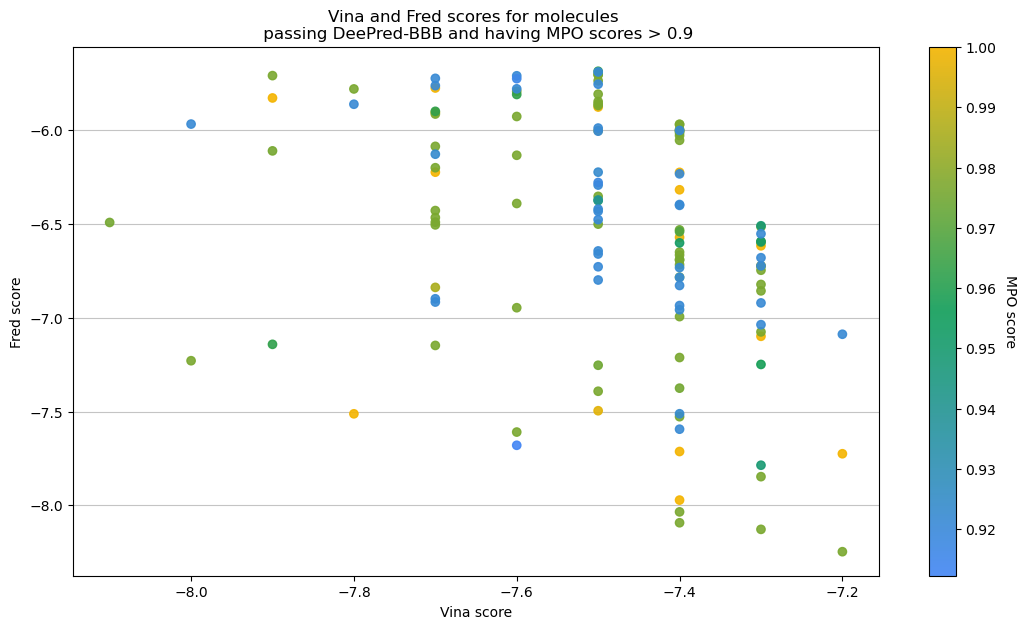

In [7]:
fig = plt.figure(dpi=100, figsize=(13, 7)) 

# Create an axis within the figure
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(axis='y', alpha=0.75, zorder=-1)
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing['MPO_score'],  cmap=custom_cmap,  alpha=0.9)

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('MPO score', rotation=270)
plt.xlabel('Vina score')
plt.ylabel('Fred score')
plt.title('Vina and Fred scores for molecules \n passing DeePred-BBB and having MPO scores > 0.9')

# # Save the plot individually as a PDF file
# plt.tight_layout()
# plt.grid(axis='y', alpha=0.75)
# plt.savefig('Vina_Fred_scores_molecules_passing_DeePred-BBB_MPOscore_over_09.pdf', format='pdf')

# pdf.savefig( fig )
plt.show()
# pdf.close()


#### Step 5.4.2: For passing data, get stricter selection based on the Vina and FRED scores

In [8]:
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold = clean_merged_mpo_predbbb_vina_fred_scores_passing.copy(deep=True)
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['FRED_threshold_for_Vina'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['VINA_score'].apply(lambda x: -2.75*x-139/5 )
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold.apply(lambda x: 1 if x['FRED_score'] <= x['FRED_threshold_for_Vina'] else 0, axis=1)
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold[clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass']==1]

,Unnamed: 0,Name,Mol_Weight,LogP,Num_H_donors,TPSA,MPO_score,DeePred-BBB Prediction,VINA_score,FRED_score,FRED_threshold_for_Vina,threshold_pass
34,34,ZINC000754688989,357.409,4.75170,0,50.52,1.000000,1,-7.4,-7.712773,-7.450,1
48,48,ZINC001216568302,348.365,4.48130,0,64.70,1.000000,1,-7.4,-7.971648,-7.450,1
122,122,ZINC000770802518,358.445,3.43412,0,51.02,1.000000,1,-7.8,-7.511780,-6.350,1
183,183,ZINC001241792879,323.399,5.18102,0,38.67,0.996308,1,-7.5,-7.495377,-7.175,1
237,237,ZINC001206018071,335.410,5.37600,0,38.67,0.985909,1,-7.7,-6.837889,-6.625,1
292,292,ZINC001534462639,344.458,4.84450,1,41.99,0.976499,1,-7.3,-7.846769,-7.725,1
376,376,ZINC001206017809,342.446,3.72360,1,41.05,0.976499,1,-7.3,-8.127644,-7.725,1
379,379,ZINC001217702527,355.441,4.95452,1,64.94,0.976499,1,-7.4,-7.527160,-7.450,1
399,399,ZINC001458129326,332.403,4.38294,1,51.22,0.976499,1,-7.4,-8.092499,-7.450,1
414,414,ZINC001243732531,326.379,2.16680,1,56.82,0.976499,1,-7.4,-8.034510,-7.450,1


Display data passing the stricter selection based on Vina and FRED scores. Passing molecules are under the diagonal

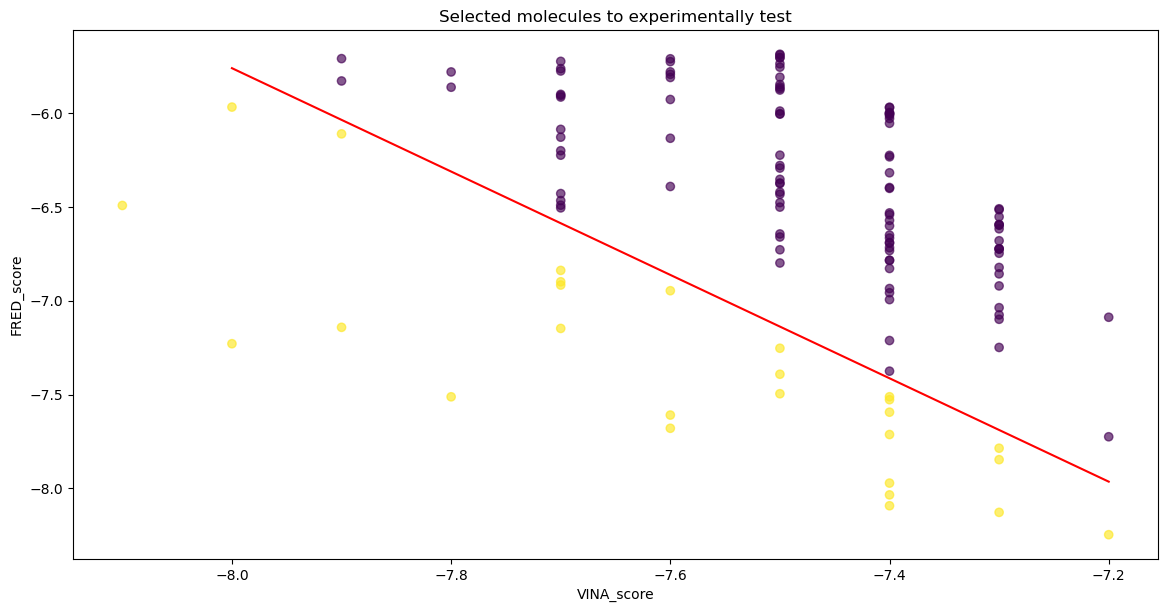

In [9]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("selection_based_on_diagonal.pdf")
fig = plt.figure(dpi=100, figsize=(14, 7)) 

plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass'],  cmap='viridis',  alpha=0.65)

x_diagonal = np.linspace(-8, -7.2, 100)
y_diagonal = -2.755*x_diagonal-139/5
plt.plot(x_diagonal, y_diagonal, c="red")
# cbar.ax.set_ylabel('Threshold pass', rotation=270)
plt.xlabel('VINA_score')
plt.ylabel('FRED_score')
plt.title('Selected molecules to experimentally test')
# pdf.savefig( fig )
plt.show()
# pdf.close()

Save the passing data.

In [15]:
# selected_clean_merged_mpo_predbbb_vina_fred_scores_passing =  clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold[clean_merged_mpo_predbbb_vina_fred_scores_passing_with_threshold['threshold_pass']==1]
# selected_clean_merged_mpo_predbbb_vina_fred_scores_passing.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test.csv', index=False)

In [16]:
# selected_top_consensus_fred_filenames_only = pd.merge(selected_clean_merged_mpo_predbbb_vina_fred_scores_passing, top_consensus_fred_filenames, on="Name")[["FRED_filename"]]
# selected_top_consensus_fred_filenames_only.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_fred_filenames.csv',  index=False, header=False)

#### Step 5.4.3: For passing data, get scricter selection based on the Vina and FRED scores (less strict)

Get also less stringent list of molecules to test.

In [12]:
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold = clean_merged_mpo_predbbb_vina_fred_scores_passing.copy(deep=True)
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['FRED_threshold_for_Vina'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['VINA_score'].apply(lambda x: -2.75*x-135.5/5 )
clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass'] = clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold.apply(lambda x: 1 if x['FRED_score'] <= x['FRED_threshold_for_Vina'] else 0, axis=1)
len(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold[clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass']==1])

59

Show molecules passing the less strict selection based on Vina and Fred scores. Molecules are under the line

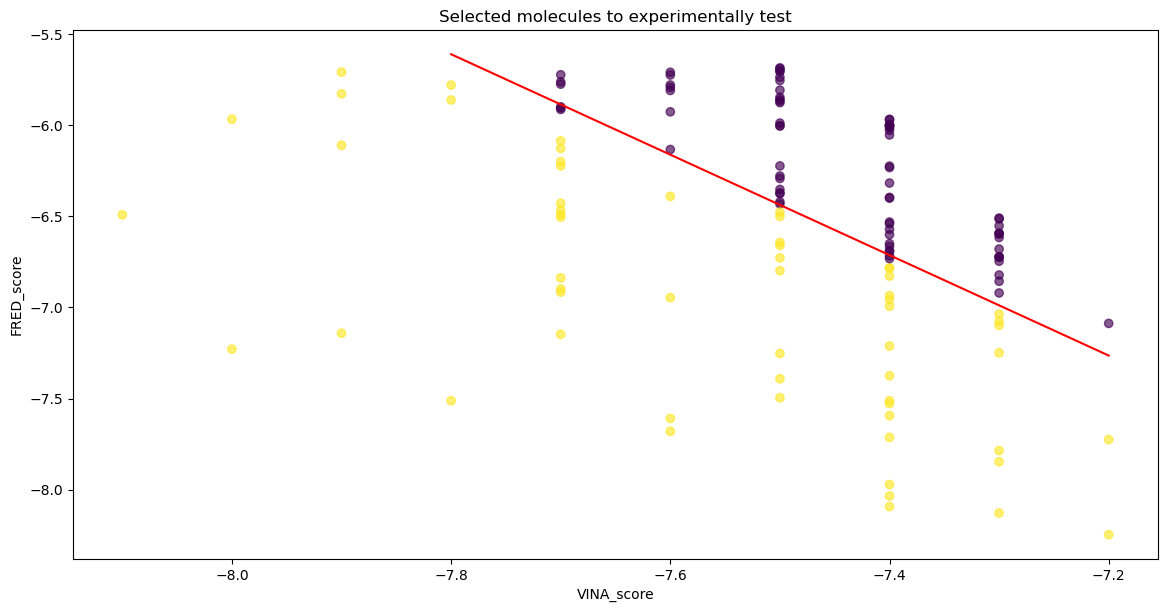

In [13]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("selection_based_on_diagonal_less_strict.pdf")
fig = plt.figure(dpi=100, figsize=(14, 7)) 

plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass'],  cmap='viridis',  alpha=0.65)

x_diagonal = np.linspace(-7.8, -7.2, 100)
y_diagonal = -2.755*x_diagonal-135.5/5
plt.plot(x_diagonal, y_diagonal, c="red")
# cbar.ax.set_ylabel('Threshold pass', rotation=270)
plt.xlabel('VINA_score')
plt.ylabel('FRED_score')
plt.title('Selected molecules to experimentally test')
# pdf.savefig( fig )
plt.show()
# pdf.close()

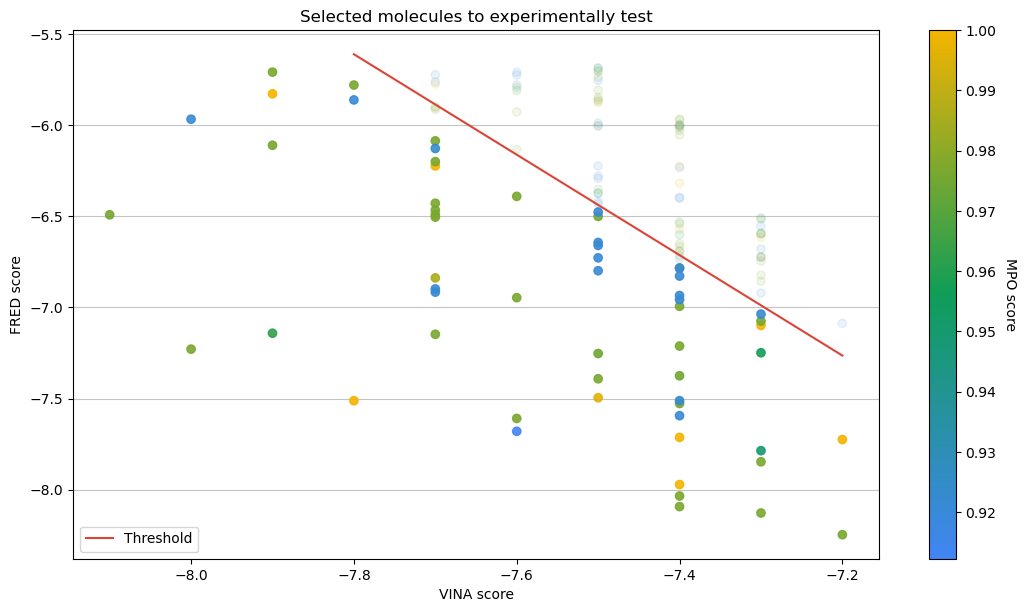

In [26]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("selection_based_on_diagonal_less_strict.pdf")
fig = plt.figure(dpi=100, figsize=(13, 7)) 

# Create an axis within the figure
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(axis='y', alpha=0.75, zorder=-1)

alpha_mapping =  {1: 0.9, 0: 0.1}
plt.scatter(clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['VINA_score'],
            clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['FRED_score'],
            c=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['MPO_score'],   cmap=custom_cmap,  alpha=clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass'].map(alpha_mapping))

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('MPO score', rotation=270)
# plt.title('Vina and Fred scores for molecules \n passing DeePred-BBB and having MPO scores > 0.9')

x_diagonal = np.linspace(-7.8, -7.2, 100)
y_diagonal = -2.755*x_diagonal-135.5/5
plt.plot(x_diagonal, y_diagonal, c="#db4437", label="threshold")
# cbar.ax.set_ylabel('Threshold pass', rotation=270)
plt.xlabel('VINA score')
plt.ylabel('FRED score')
plt.title('Selected molecules to experimentally test')
plt.legend(loc="lower left")
# pdf.savefig( fig )

plt.savefig('Vina_Fred_scores_molecules_selected_passing_DeePredBBB_and_MPO_score.pdf', format='pdf')
plt.show()
# pdf.close()

Save the less strictly selected molecules

In [89]:
selected_looser_threshold_clean_merged_mpo_predbbb_vina_fred_scores_passing =  clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold[clean_merged_mpo_predbbb_vina_fred_scores_passing_with_looser_threshold['threshold_pass']==1]
# selected_looser_threshold_clean_merged_mpo_predbbb_vina_fred_scores_passing.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict.csv', index=False)

In [90]:
selected_looser_threshold_top_consensus_fred_filenames_only = pd.merge(selected_looser_threshold_clean_merged_mpo_predbbb_vina_fred_scores_passing, top_consensus_fred_filenames, on="Name")[["FRED_filename"]]
# selected_looser_threshold_top_consensus_fred_filenames_only.to_csv('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict_fred_filenames.csv',  index=False, header=False)

#### Step 5.5: Get SDFs of selected top molecules (for both levels of strictness)

In [91]:
#!while read p; do cat "$p" >> clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test.sdf ; done<clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_fred_filenames.csv
#!while read p; do cat "$p" >> clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict.sdf ; done<clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test_less_strict_fred_filenames.csv

In [32]:
# molecules = [x for x in Chem.ForwardSDMolSupplier(open('/home/mb2462/rds/hpc-work/DD/DD_protocol_data/DD_main_clean/clustering/clustering_results/molecule_testing/top_consensus_fred.sdf','rb')) if x is not None]
# # mol.GetProp('_Name')
# with Chem.SDWriter('clustering_results/molecule_testing/top_consensus_selected_to_experimentally_test.sdf') as w:
#     for m in molecules:
#         print(m.GetProp('_Name'))
#         if selected_clean_merged_mpo_predbbb_vina_fred_scores_passing['Name'].str.contains(m.GetProp('_Name')).any():
#             w.write(m)

## Useful (bash commands)

1. Get line(s) that contain the given string ("the_string")

In [41]:
# grep -hnr "singletons" extracted_smiles_clusters_1024_full.txt

# OBSOLETE CODE

## Testing fingerprints

In [3]:
m = Chem.MolFromSmiles("Cc1nc(on1)c2ccc(nc2)NCc3ccc(cc3)N4CCCC4")


In [5]:
# fp = AllChem.GetHashedMorganFingerprint(m, 2, nBits=2048)
# array = np.zeros((0,), dtype=np.int8)
# DataStructs.ConvertToNumpyArray(fp, array)
# print(array[array.nonzero()])

In [6]:
fp2 = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024, useChirality=True)
array2 = np.zeros((0, ), dtype=np.int8)
DataStructs.ConvertToNumpyArray(fp2, array2)
print(array2.nonzero())

(array([   4,    8,   12,   23,   33,   36,   75,   80,  102,  128,  136,
        233,  248,  255,  265,  310,  356,  378,  381,  392,  407,  428,
        439,  456,  463,  511,  518,  607,  638,  656,  680,  687,  698,
        726,  730,  801,  831,  836,  849,  896,  897,  926,  935,  967,
        974,  980, 1023]),)


In [8]:
# arena = chemfp.load_fingerprints("clustering/testing_chemfp/test_smiles-isomers_1024.fps")

In [10]:

# bz = Chem.MolFromSmiles('c1ccccc1')
# fp_bz = AllChem.GetMorganFingerprintAsBitVect(bz,radius=2,nBits=1024)
# pyr = Chem.MolFromSmiles('c1ccccc1')
# fp_pyr = AllChem.GetMorganFingerprintAsBitVect(pyr,radius=2,nBits=1024)
# print("Similarity:",DataStructs.TanimotoSimilarity(fp_bz,fp_pyr))

# print("intersection count:",(fp_bz&fp_pyr).GetNumOnBits())
# print("union count:",(fp_bz|fp_pyr).GetNumOnBits())

## FRED RESULTS

Concat results into a single file

In [17]:
# for f in fred_docked/*/*_docking_results.txt; do awk -F$'\t' '{print $1, $2, FILENAME}' $f >> fred_docking_scores.txt; done

In [1]:
# python get_top_molecules.py

In [ ]:
# DEPRECATED
# sort -t$',' -n -k 1  clusters_selected_molecules.txt | awk -F$',' '{print $2}' > VINA_sorted_100K.txt
# sort -t$'\t' -n -k 2  fred_docking_scores.txt | awk -F$'\t' '{print $1}' > FRED_sorted_100K.txt


In [40]:
# vina_docked = pd.read_csv("clustering_results/molecule_testing/clusters_selected_molecules.txt")
# fred_docked = pd.read_csv("clustering_results/molecule_testing/fred_docking_scores.txt",delimiter=' ', names=['ZINC_ID', "FRED_score", "chunk"] )
# ligands_2d = pd.read_csv("clustering_results/molecule_testing/2D_ligands.txt", names=['ZINC_ID'])

In [39]:
# top_1000 = pd.read_csv("clustering_results/molecule_testing/final_selected_1000.csv")

# top_1000  = top_1000.drop('VINA_filename', axis=1)
# top_1000  = top_1000.drop('FRED_filename', axis=1)
# top_1000  = top_1000.drop(top_1000.columns[0], axis=1)
# top_1000 = top_1000.sort_values('FRED_score')
# # top_1000.to_csv('clustering_results/molecule_testing/final_selected_only_scores.csv', index=False)


# vina_cleaned = pd.merge(vina_docked, ligands_2d, on='ZINC_ID',how='left', indicator=True)
# vina_cleaned =  vina_cleaned[vina_cleaned['_merge'] == 'left_only']
# vina_cleaned_sorted = vina_cleaned.sort_values('r_i_docking_score')
# vina_cleaned_sorted = vina_cleaned_sorted.drop('file',axis=1)
# vina_cleaned_sorted = vina_cleaned_sorted.drop('_merge',axis=1)
# # vina_cleaned_sorted.to_csv('clustering_results/molecule_testing/sorted_vina_scores.csv', index=False)

# fred_cleaned = pd.merge(fred_docked, ligands_2d, on='ZINC_ID',how='left', indicator=True)
# fred_cleaned =  fred_cleaned[fred_cleaned['_merge'] == 'left_only']
# fred_cleaned_sorted = fred_cleaned.sort_values('FRED_score')
# fred_cleaned_sorted = fred_cleaned_sorted.drop('chunk',axis=1)
# fred_cleaned_sorted = fred_cleaned_sorted.drop('_merge',axis=1)
# # fred_cleaned_sorted.to_csv('clustering_results/molecule_testing/sorted_fred_scores.csv', index=False)



In [38]:
# # fred_cleaned_sorted
# top_1000.sort_values('VINA_score')

In [35]:
# ligands_both_scores = pd.merge(vina_cleaned_sorted, fred_cleaned_sorted, on='ZINC_ID')
# ligands_both_scores= ligands_both_scores[['ZINC_ID', "r_i_docking_score", "FRED_score"]]
# ligands_both_scores = ligands_both_scores.rename(columns={'r_i_docking_score' : "VINA_score"})
# # ligands_both_scores.to_csv('clustering_results/molecule_testing/vina_and_fred_scores.csv', index=False)

In [36]:
# ligands_both_scores['VINA_score_normalized'] = (ligands_both_scores['VINA_score']-ligands_both_scores['VINA_score'].min())/(ligands_both_scores['VINA_score'].max()-ligands_both_scores['VINA_score'].min())
# ligands_both_scores['FRED_score_normalized'] = (ligands_both_scores['FRED_score']-ligands_both_scores['FRED_score'].min())/(ligands_both_scores['FRED_score'].max()-ligands_both_scores['FRED_score'].min())


In [37]:
# ligands_both_scores['joined_score_normalized'] = ligands_both_scores['VINA_score_normalized'] + ligands_both_scores['FRED_score_normalized']
# ligands_both_scores.sort_values('joined_score_normalized').head(1000)